In [1]:
import os
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [14]:

def group_files_by_work_order(dir_path):
    # 存储每个工单号对应的文件路径
    work_order_files = defaultdict(list)

    # 遍历文件夹中的所有文件
    for filename in os.listdir(dir_path):
        if filename.endswith('.txt'):
            # 提取工单号（假设工单号与文件名的开头部分匹配）
            try:
                work_order_number = filename.split('-')[0]
                file_path = os.path.join(dir_path, filename)
                work_order_files[work_order_number].append(file_path)
            except IndexError:
                # 如果文件名格式不符合规范，忽略
                continue
    # 将所有工单号对应的文件路径列表放在一个大列表中
    result = list(work_order_files.values())

    return result

def yolo_result(label_path_lst):
    '''
    image-list[
            box-list[
                yolo result: cls,x,y,w,h,prob
            ]
        ]
    '''
    bbu_sheild_detect_lst = []
    for file_path in label_path_lst:
        image_lst = []
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split(' ')
                image_lst.append(list(map(float, parts)))
        bbu_sheild_detect_lst.append(image_lst)
    return bbu_sheild_detect_lst

def inference(bbu_sheild_detect_lst,threshold):
    '''
    image-list[
            box-list[
                cls,x,y,w,h,prob
            ]
        ]
    '''
    # 遍历每一个图片
    max_bbu,max_sheild = 0,0
    bbu_with_shield = False
    special_shot = False
    broad_shot = False
    has_huawei_bbu = False

    if len(bbu_sheild_detect_lst)!=1:
        for image_lst in bbu_sheild_detect_lst:
            all_bbus = 0
            all_shields = 0
            for box_lst in image_lst:
                cls, cx, cy, w, h, c = box_lst
                if c < threshold: continue
                cls = int(cls)

                
                if cls in {0, 3}:  # BBU类
                    all_bbus += 1
                    if cls == 0: has_huawei_bbu = True
                elif cls in {2, 4}:  # Shield类
                    all_shields += 1
            if all_bbus + all_shields >=2:
                broad_shot = True
            if all_bbus + all_shields <=2:
                special_shot = True
                
            

        max_bbu = max(max_bbu,all_bbus)
        max_sheild = max(max_sheild,all_shields)

    bbu_with_shield = max_bbu <= max_sheild and max_sheild!=0  # BBU 是否被 Shield 覆盖
    return bbu_with_shield, special_shot, broad_shot, has_huawei_bbu
        
def check(files_lst,threshold):
    '''
    yolo返回的分类class对应的名称，txt中存储格式为cls,cx,cy,w,h

    0 huawei_bbu
    1 alx_bbu
    2 huawei_shield
    3 zhongxing_bbu
    4 zhongxing_shield
    提议：
    1. 需要判断是否有特写照片：图片数量不为1张，其中存在照片num bbu + num sheild <=2 且 存在照片 num bbu + num sheild >=2
    '''

    # 判断一个工单内是否有照片为bbu与sheild间隔的，若有则判断正，否则判负
    total_work_orders = len(files_lst)
    negative_work_orders = 0
    pos_file_path_dic = {}
    neg_file_path_dic = {}

    # 遍历每一个工单
    for label_path_lst in files_lst:
        # 遍历每一个图片
        bbu_sheild_detect_lst = yolo_result(label_path_lst)
        bbu_with_shield, special_shot, broad_shot, has_huawei_bbu =inference(bbu_sheild_detect_lst,threshold)
        bbu_with_shield &= special_shot and broad_shot
            
        file_id = label_path_lst[0].split('/')[-1].split('-')[0]
        
        if not bbu_with_shield:
            negative_work_orders += 1
            neg_file_path_dic[file_id] = label_path_lst
        else:
            pos_file_path_dic[file_id] = label_path_lst

    return negative_work_orders, total_work_orders,pos_file_path_dic,neg_file_path_dic




In [15]:
def check_temp(files_lst,neg_lst,threshold):
    '''
    yolo返回的分类class对应的名称，txt中存储格式为cls,cx,cy,w,h

    0 huawei_bbu
    1 alx_bbu
    2 huawei_shield
    3 zhongxing_bbu
    4 zhongxing_shield
    '''

    # 判断一个工单内是否有照片为bbu与sheild间隔的，若有则判断正，否则判负
    total_work_orders = len(files_lst)
    negative_work_orders = 0
    file_path_dic = {}

    # 遍历每一个工单
    for label_path_lst in files_lst:
        # 遍历每一个图片
        for file_path in label_path_lst:
            all_bbus = 0
            all_shields = 0
            bbu_with_shield = True
            arrow_correct = True
            with open(file_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split(' ')
                    cls, cx, cy, w, h, c = map(float, parts)
                    if c < threshold: continue
                    cls = int(cls)

                    if cls == 0 and file_path.split('/')[-1] in neg_lst:
                        arrow_correct = False
                        break
                    
                    if cls in {0, 3}:  # BBU类
                        all_bbus += 1
                    elif cls in {2, 4}:  # Shield类
                        all_shields += 1
            # bbu_with_shield = all_bbus <= all_shields+1 and all_shields!=0  # BBU 是否被 Shield 覆盖
            bbu_with_shield = all_bbus <= all_shields and all_shields!=0  # BBU 是否被 Shield 覆盖
            bbu_with_shield &= arrow_correct
            if bbu_with_shield: break

        if not bbu_with_shield:
            negative_work_orders += 1
        else:
            file_id = label_path_lst[0].split('/')[-1].split('-')[0]
            file_path_dic[file_id] = label_path_lst

    return negative_work_orders, total_work_orders,file_path_dic

In [17]:
root_path = './runs/detect/v7-p5-lr_1e-3'
# root_path = './runs/detect/v7-e6e-p6-bs96-ep1000-lr_1e-3'
# dir_path = root_path+'/pos/labels'

# 整理数据以一个工单为一组图片，文件命名规则为'工单号-图片序号.txt'，同一工单下会有多张图片
neg_files_lst = group_files_by_work_order(root_path+'/neg/labels')
# pos_files_lst = group_files_by_work_order(root_path+'/pos/labels')
pos_files_lst = group_files_by_work_order(root_path+'/pos/labels')[:len(neg_files_lst)]


# image_path = '/1004034-0.txt'
# file_path = dir_path+image_path

threshold = 0.41

false_neg, total_pos, _, neg_path_dic_from_pos = check(pos_files_lst,threshold)
true_neg, total_neg,pos_path_dic_from_neg, _ = check(neg_files_lst,threshold)

true_pos = total_pos - false_neg
false_pos = total_neg - true_neg

print('AI判正的数据中误判比例',false_pos/(true_pos+false_pos))
print(f"TP:{true_pos},FP:{false_pos}")
print('正样本中判正比例',true_pos/total_pos)
print('负样本中判负比例',true_neg/total_neg)
print("match-ratio:",0.5*(true_pos/total_pos + true_neg/total_neg))
# 正确的保证5%是误判，错误的

AI判正的数据中误判比例 0.09558823529411764
TP:123,FP:13
正样本中判正比例 0.6721311475409836
负样本中判负比例 0.9289617486338798
match-ratio: 0.8005464480874317


In [18]:
print(true_pos, false_neg)
print(false_pos,true_neg)

123 60
13 170


In [19]:
def notEnough_image_counter(files_lst):
    counter = 0
    for lst in files_lst:
        if len(lst)==1:
            counter +=1
    return counter

false_neg = notEnough_image_counter(pos_files_lst)
ture_neg = notEnough_image_counter(neg_files_lst)

n = len(pos_files_lst)
true_pos = n - false_neg
false_pos = n - true_neg

print('AI判正的数据中误判比例',false_pos/(true_pos+false_pos))
print(f"TP:{true_pos},FP:{false_pos}")
print('正样本中判正比例',true_pos/n)
print('负样本中判负比例',true_neg/n)
print("match-ratio:",0.5*(true_pos/n + true_neg/n))

AI判正的数据中误判比例 0.07222222222222222
TP:167,FP:13
正样本中判正比例 0.912568306010929
负样本中判负比例 0.9289617486338798
match-ratio: 0.9207650273224044


In [20]:
false_neg/len(pos_files_lst)

0.08743169398907104

In [21]:
arrow_tn_set = [
"2179213-0.txt",
"2052517-2.txt",
"762759-2.txt",
"1016927-0.txt",
"617443-3.txt",
"1542969-0.txt",
"896438-0.txt",
"1726834-3.txt",
"886078-0.txt",
"2273296-1.txt",
"786066-0.txt",
"2213661-1.txt",
"517360-0.txt",
"864685-0.txt",
"2102641-0.txt",
"1100860-0.txt",
"683032-0.txt",
"1137529-0.txt",
"2214301-0.txt",
"756324-0.txt",
"754593-0.txt",
"2193493-0.txt",
"2065564-0.txt",
"2161306-0.txt",
"2007220-0.txt",
"2179232-0.txt",
"2007220-1.txt",
"2213661-0.txt",
"2135785-0.txt",
"893117-1.txt"]

In [22]:
# 获取Pos中箭头判断为负的数据
false_neg_lst = []
with open("pos_file.txt") as file:
    lines = file.readlines()
    for line in lines:
        false_neg_lst.append(line.strip().split('.')[0]+'.txt')

In [23]:
def test(threshold):
    root_path = './runs/detect/v7-p5-lr_1e-3'
    # root_path = './runs/detect/v7-e6e-p6-bs96-ep1000-lr_1e-3'
    
    neg_files_lst = group_files_by_work_order(root_path+'/neg/labels')
    pos_files_lst = group_files_by_work_order(root_path+'/pos/labels')[:len(neg_files_lst)]

    # false_neg, total_pos,path_dic_pos = check_temp(pos_files_lst,false_neg_lst,threshold)
    # true_neg, total_neg,path_dic_neg = check_temp(neg_files_lst,arrow_tn_set,threshold)
    false_neg, total_pos,_,path_dic_pos = check(pos_files_lst,threshold)
    true_neg, total_neg,path_dic_neg,_ = check(neg_files_lst,threshold)


    true_pos = total_pos - false_neg
    false_pos = total_neg - true_neg

    ai_match = ((true_pos/total_pos)+(true_neg/total_neg))/2
    tnr = false_pos/(true_pos+false_pos)
    
    return tnr,ai_match
# print('AI判正的数据中误判比例',false_pos/(true_pos+false_pos))
# print('正样本中判正比例',true_pos/total_pos)
# print('负样本中判负比例',true_neg/total_neg)

In [24]:
precise_lst, ai_match_lst = [],[]
end_point = 87
for i in range(0,end_point,1):
    tnr,ai_match = test(i/100.0)
    precise_lst.append(1-tnr)
    ai_match_lst.append(ai_match)

In [25]:
i

86

/tmp/ipykernel_63934/3960038598.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


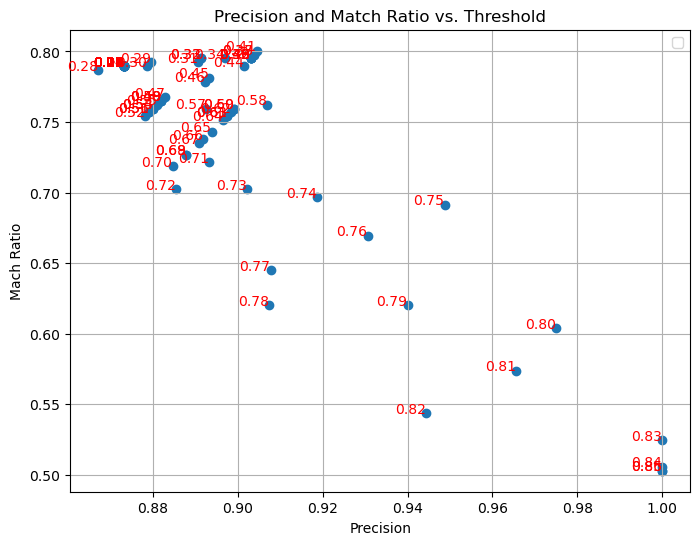

In [26]:



# 计算 Precision, Recall 和 阈值
thresholds = [i/100 for i in range(0,end_point,1)]

# 计算 F1-score 用于选择最佳阈值
f1_scores = 2 * (np.array(precise_lst) * np.array(ai_match_lst)) / (np.array(precise_lst) + np.array(ai_match_lst))

# 找到最大 F1-score 对应的阈值
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# 可视化 Precision-Recall 曲线
plt.figure(figsize=(8, 6))
plt.scatter(precise_lst, ai_match_lst, marker="o")
for i, threshold in enumerate(thresholds):
    plt.text(precise_lst[i], ai_match_lst[i], f'{threshold:.2f}', fontsize=10, ha='right', color='red')
# plt.plot(thresholds, ai_match_lst, label="Match Ratio", marker="x")
plt.xlabel("Precision")
plt.ylabel("Mach Ratio")
plt.title("Precision and Match Ratio vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# # 输出最佳阈值
# print(f"最佳阈值为: {best_threshold}")
# print(f"对应的最大 F1-score: {best_f1}")

In [27]:
best_threshold,best_f1

(0.41, 0.8493153913227912)

In [61]:
indices = [i for i, value in enumerate(precise_lst) if 0.8 < value < 0.85]

In [64]:
thresholds[indices[0]]

0.84

In [121]:
precise_lst[np.argmax(f1_scores)], ai_match_lst[np.argmax(f1_scores)]

(0.7380952380952381, 0.7185792349726776)

## 导出列表中的图片到文件夹

In [49]:
import shutil
def save_image_to_dir(dest_dir, path_dic):
    # 创建每个工单号对应的子文件夹并复制文件
    for work_order_number, file_paths in path_dic.items():
        # 创建工单号对应的子文件夹
        work_order_folder = os.path.join(dest_dir, work_order_number)
        if not os.path.exists(work_order_folder):
            os.makedirs(work_order_folder)
        
        # 复制文件到对应的子文件夹
        for file_path in file_paths:
            shutil.copy(file_path, os.path.join(work_order_folder, os.path.basename(file_path)))
            image_path = file_path.replace("labels/", "").replace(".txt", ".jpeg")
            shutil.copy(image_path, os.path.join(work_order_folder, os.path.basename(image_path)))

In [50]:
neg_in_pos_dest_dir = './tmp_image_dir/neg_in_pos'
pos_in_neg_dest_dir = './tmp_image_dir/pos_in_neg'

save_image_to_dir(neg_in_pos_dest_dir, neg_path_dic_from_pos)
save_image_to_dir(pos_in_neg_dest_dir, pos_path_dic_from_neg)

In [52]:
len(neg_path_dic_from_pos), len(pos_path_dic_from_neg)

(56, 70)

## 判断错误的情况
1. 局部照片看到的bbu数量少于挡风板，所以被判正，但全景图是可以发现问题的 工单号648019
1. 

In [68]:
false_neg_lst

['648057-2.jpeg',
 '2052523-1.jpeg',
 '923065-0.jpeg',
 '981683-2.jpeg',
 '669651-2.jpeg',
 '1252055-2.jpeg',
 '1130402-2.jpeg',
 '810605-0.jpeg',
 '761757-1.jpeg',
 '1984684-0.jpeg',
 '766856-2.jpeg',
 '972683-1.jpeg',
 '766979-0.jpeg',
 '631984-1.jpeg',
 '706043-2.jpeg',
 '669609-2.jpeg',
 '864921-2.jpeg',
 '807166-1.jpeg',
 '868227-2.jpeg',
 '1133032-0.jpeg',
 '1206315-2.jpeg',
 '765800-2.jpeg',
 '1076136-1.jpeg',
 '740319-2.jpeg',
 '1159368-0.jpeg',
 '1158540-0.jpeg',
 '879274-0.jpeg',
 '756266-1.jpeg',
 '910743-2.jpeg',
 '1137344-0.jpeg',
 '697163-2.jpeg',
 '756299-2.jpeg',
 '782379-0.jpeg',
 '1353225-2.jpeg',
 '1018645-1.jpeg',
 '669635-0.jpeg',
 '756286-0.jpeg',
 '745564-0.jpeg',
 '681471-2.jpeg',
 '1298750-2.jpeg',
 '767674-0.jpeg',
 '312796-1.jpeg',
 '1311928-1.jpeg',
 '1319986-2.jpeg',
 '2101139-0.jpeg',
 '885547-1.jpeg',
 '811097-0.jpeg',
 '999155-2.jpeg',
 '844355-2.jpeg',
 '766882-2.jpeg',
 '854371-1.jpeg',
 '622069-2.jpeg',
 '767674-2.jpeg',
 '1265125-2.jpeg',
 '770782-2.

In [64]:
#整理ARROW判断的数据结果
# pos中判断为neg的数据在pos_file.txt
# neg中判断为neg的数据在arrow_tn_set中
# 目标数据整理为两个文件pos_arrow.txt和neg_arrow.txt

dir_path = root_path+'/neg/labels'
# 存储每个工单号对应的文件路径
neg_work_order_files = defaultdict(list)

# 遍历文件夹中的所有文件
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        # 提取工单号（假设工单号与文件名的开头部分匹配）
        try:
            work_order_number = filename.split('-')[0]
            if filename in arrow_tn_set:
                tmp_dic = {filename:0}
            else:
                tmp_dic = {filename:1}
            neg_work_order_files[work_order_number].append(tmp_dic)
        except IndexError:
            # 如果文件名格式不符合规范，忽略
            continue
# 将所有工单号对应的文件路径列表放在一个大列表中
neg_work_order_files

defaultdict(list,
            {'2052527': [{'2052527-1.txt': 1}, {'2052527-0.txt': 1}],
             '937009': [{'937009-0.txt': 1}],
             '994160': [{'994160-0.txt': 1}, {'994160-1.txt': 1}],
             '663551': [{'663551-0.txt': 1}],
             '1019119': [{'1019119-0.txt': 1}, {'1019119-2.txt': 1}],
             '676239': [{'676239-0.txt': 1}],
             '882656': [{'882656-1.txt': 1}],
             '846452': [{'846452-0.txt': 1}],
             '1144162': [{'1144162-0.txt': 1}],
             '2135776': [{'2135776-0.txt': 1}],
             '1033460': [{'1033460-0.txt': 1}],
             '2179232': [{'2179232-1.txt': 1},
              {'2179232-2.txt': 1},
              {'2179232-0.txt': 0}],
             '1016927': [{'1016927-0.txt': 0}],
             '1975644': [{'1975644-0.txt': 1}],
             '937055': [{'937055-0.txt': 1}],
             '2028414': [{'2028414-0.txt': 1}, {'2028414-1.txt': 1}],
             '612091': [{'612091-0.txt': 1}],
             '1970696':